**ALGORITHM: DeepAR**

---






> ***Import Libraries***







In [ ]:
!pip install gluonts
!pip install mxnet
!pip install gluonts.model.deepar

#!pip install --upgrade mxnet==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement gluonts.model.deepar (from versions: none)
ERROR: No matching distribution found for gluonts.model.deepar


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis
from scipy.stats import skew

from sklearn.model_selection import train_test_split

from gluonts.dataset.common import ListDataset
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.field_names import FieldName

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(




***1.   Data Collection***






> ***Data Loading***



In [ ]:
df = pd.read_csv("/content/XOM.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100
...,...,...,...,...,...,...,...
1332,2023-04-19,116.080002,116.900002,115.769997,116.570000,116.570000,10682600
1333,2023-04-20,115.129997,115.680000,113.230003,115.639999,115.639999,17038700
1334,2023-04-21,116.489998,116.879997,115.260002,116.010002,116.010002,14313800
1335,2023-04-24,115.919998,118.889999,115.879997,118.199997,118.199997,15831300


In [ ]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,83.820000,85.199997,83.660004,85.029999,64.879845,11469300
1,2018-01-03,85.160004,86.970001,84.820000,86.699997,66.154083,13957700
2,2018-01-04,86.790001,87.220001,86.430000,86.820000,66.245667,10863000
3,2018-01-05,86.750000,86.879997,85.709999,86.750000,66.192230,11047600
4,2018-01-08,86.699997,87.150002,86.599998,87.139999,66.489830,10927100
5,2018-01-09,86.940002,87.150002,86.650002,86.769997,66.207489,8131600
6,2018-01-10,87.000000,87.190002,85.980003,86.080002,65.681007,10822300
7,2018-01-11,86.360001,87.370003,85.930000,86.930000,66.329590,14366000
8,2018-01-12,87.199997,87.989998,87.180000,87.519997,66.779762,9834500
9,2018-01-16,87.739998,87.760002,86.599998,86.970001,66.360107,10882800




> ***Descriptive Statistical***





> ***Detail Statistical***



In [ ]:
df_drop_date=df.drop('Date', axis=1)
detail_statistical= df_drop_date.describe()
detail_statistical


,Open,High,Low,Close,Adj Close,Volume
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03
mean,71.965453,72.775034,71.162521,71.981159,63.709470,2.044246e+07
std,20.246180,20.429780,20.118105,20.321002,21.213097,1.081068e+07
min,31.410000,32.380001,30.110001,31.450001,26.564503,3.979400e+06
25%,58.009998,58.880001,57.320000,58.200001,52.986561,1.278670e+07
50%,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07
75%,82.730003,83.309998,82.000000,82.690002,67.428345,2.551770e+07
max,117.720001,119.629997,116.160004,119.169998,118.260002,8.443940e+07


In [ ]:
mode_dict = {}
median_dict ={}
variance_dict = {}

for column in df_drop_date.columns:
    mode_dict[column] = df_drop_date[column].mode()[0]
    median_dict[column] = df_drop_date[column].median()
    variance_dict[column] = df_drop_date[column].var()

# Convert the mode_dict to a DataFrame and transpose it
mode_df = pd.DataFrame.from_dict(mode_dict, orient='index', columns=['mode']).transpose()
median_df = pd.DataFrame.from_dict(median_dict, orient='index', columns=['median']).transpose()
variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance']).transpose()

cv_df = pd.DataFrame(df_drop_date.apply(lambda x: np.std(x) / np.mean(x)).rename('CV')).T
kurtosis_df = pd.DataFrame(df_drop_date.apply(lambda x: kurtosis(x)).rename('Kurtosis')).T
skew_df = pd.DataFrame(df_drop_date.apply(lambda x: skew(x)).rename('Skewness')).T


In [ ]:
detail_statistical = pd.concat([detail_statistical, mode_df], axis=0)
detail_statistical = pd.concat([detail_statistical, median_df], axis=0)
detail_statistical = pd.concat([detail_statistical, variance_df], axis=0)
detail_statistical = pd.concat([detail_statistical, cv_df], axis=0)
detail_statistical = pd.concat([detail_statistical, kurtosis_df], axis=0)

detail_statistical

,Open,High,Low,Close,Adj Close,Volume
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1.337000e+03
mean,71.965453,72.775034,71.162521,71.981159,63.709470,2.044246e+07
std,20.246180,20.429780,20.118105,20.321002,21.213097,1.081068e+07
min,31.410000,32.380001,30.110001,31.450001,26.564503,3.979400e+06
25%,58.009998,58.880001,57.320000,58.200001,52.986561,1.278670e+07
50%,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07
75%,82.730003,83.309998,82.000000,82.690002,67.428345,2.551770e+07
max,117.720001,119.629997,116.160004,119.169998,118.260002,8.443940e+07
mode,80.809998,80.260002,82.559998,60.930000,57.711708,1.104760e+07
median,73.820000,74.400002,73.040001,73.730003,59.766808,1.787550e+07






> ***Visualization***





In [ ]:
columns= df_drop_date.columns
columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

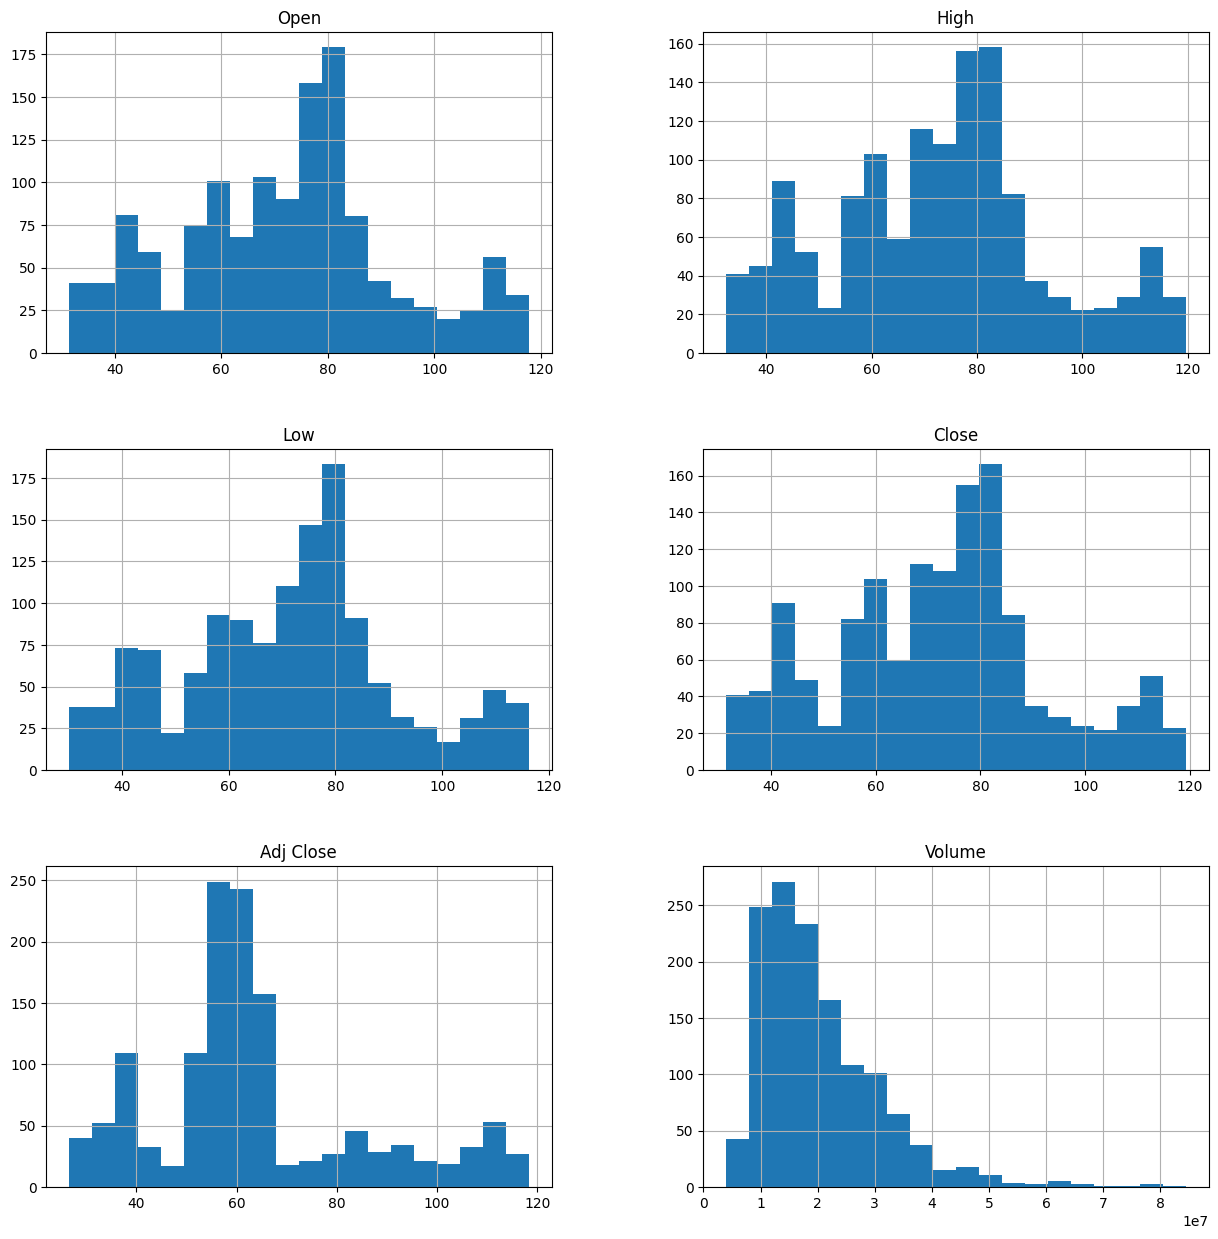

In [ ]:
df_drop_date[df_drop_date.columns].hist(figsize=(15,15), bins=20)

In [ ]:
data = pd.read_csv("/content/XOM.csv")
def descriptive_summary(column):
    fig, axs = plt.subplots(1,2, figsize=(19,6))
    axs[0].hist(data[column]) #creating histogram plot
    axs[0].axvline(data[column].mean(), color='red', label=f"Mean: {round(data[column].mean(),2)}") #vertical line for mean of the distribution
    axs[0].axvline(data[column].median(), color='green', label=f"Median: {round(data[column].median(),2)}") #vertical line for median of the distribution
    axs[0].axvline(x=data[column].describe()[4],color='r', linestyle='--', label=f"25th percentile: {data[column].describe()[4]}") #vertical line for 25th percentile of the distribution
    axs[0].axvline(x=data[column].describe()[6],color='r', linestyle='--', label=f"75th percentile: {data[column].describe()[6]}") #vertical line for 75th percentile of the distribution
    axs[0].legend()
    sns.boxplot(data=data, x=column, ax=axs[1]) #creating boxplot
    axs[1].axvline(data[column].mean(), color='red') #vertical line for the mean of the distribution
    fig.suptitle(f"Histogram and Boxplot of {column}")
    plt.show()
    print(f"{data[column].describe().round(3)}\n")
    print(f"Range: {data[column].max() - data[column].min()}")
    print(f"Interquartile Range: {data[column].describe()[6] - data[column].describe()[4]}\n")
    print(f"Skewness: {skew(data[data[column].isna()==False][column], bias=True)}")
    print(f"Kurtosis: {kurtosis(data[data[column].isna()==False][column], bias=True)}")

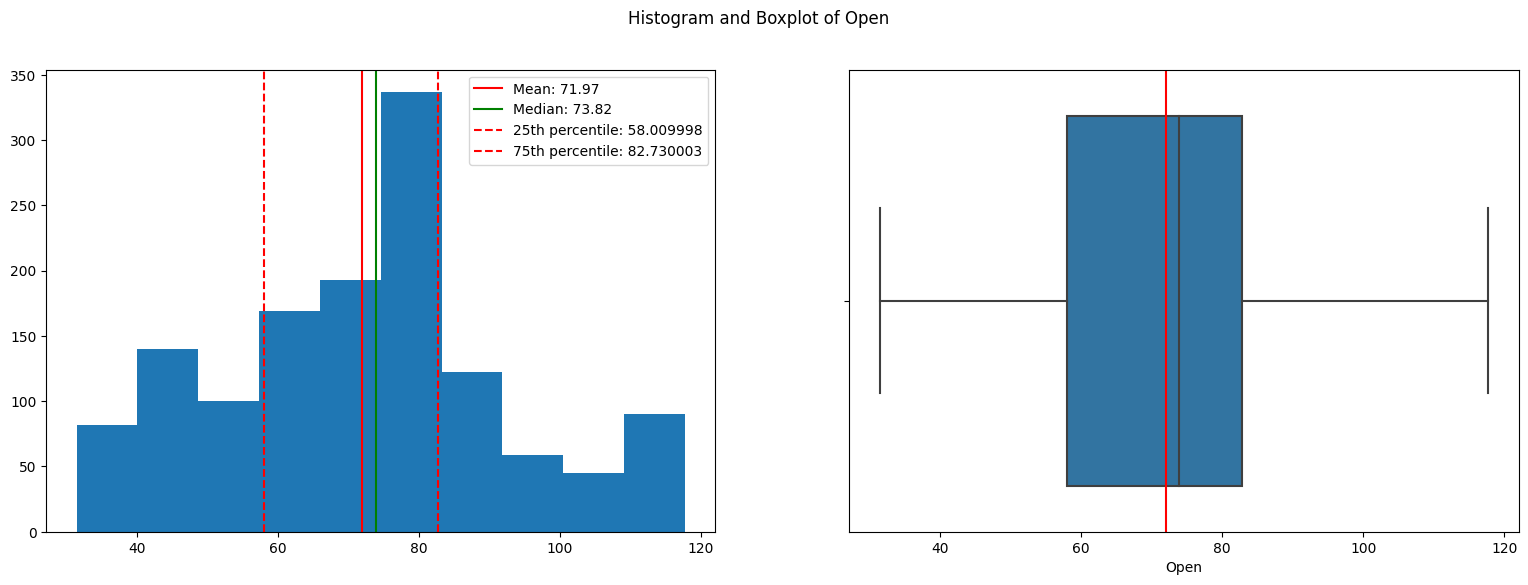

count    1337.000
mean       71.965
std        20.246
min        31.410
25%        58.010
50%        73.820
75%        82.730
max       117.720
Name: Open, dtype: float64

Range: 86.310001
Interquartile Range: 24.720004999999993

Skewness: 0.12225086808394776
Kurtosis: -0.4188869438570588


In [ ]:
descriptive_summary(columns[0])

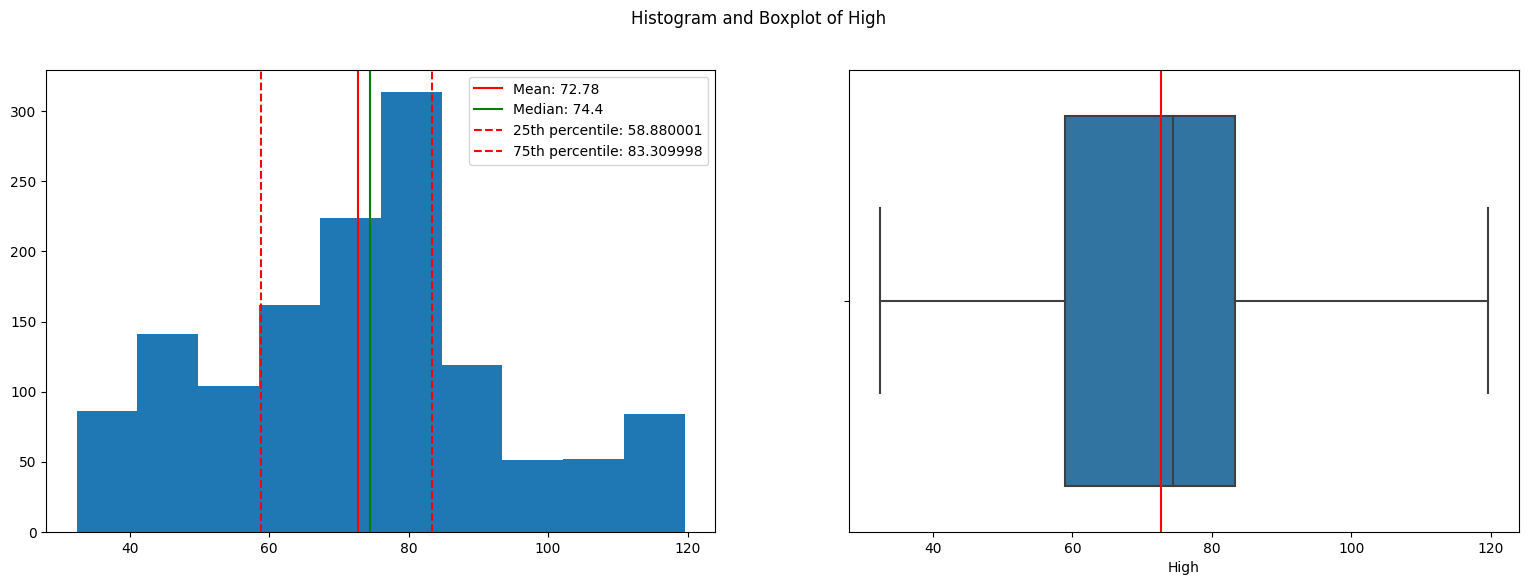

count    1337.000
mean       72.775
std        20.430
min        32.380
25%        58.880
50%        74.400
75%        83.310
max       119.630
Name: High, dtype: float64

Range: 87.24999600000001
Interquartile Range: 24.429996999999993

Skewness: 0.15014697627630247
Kurtosis: -0.4173526920772699


In [ ]:
descriptive_summary(columns[1])

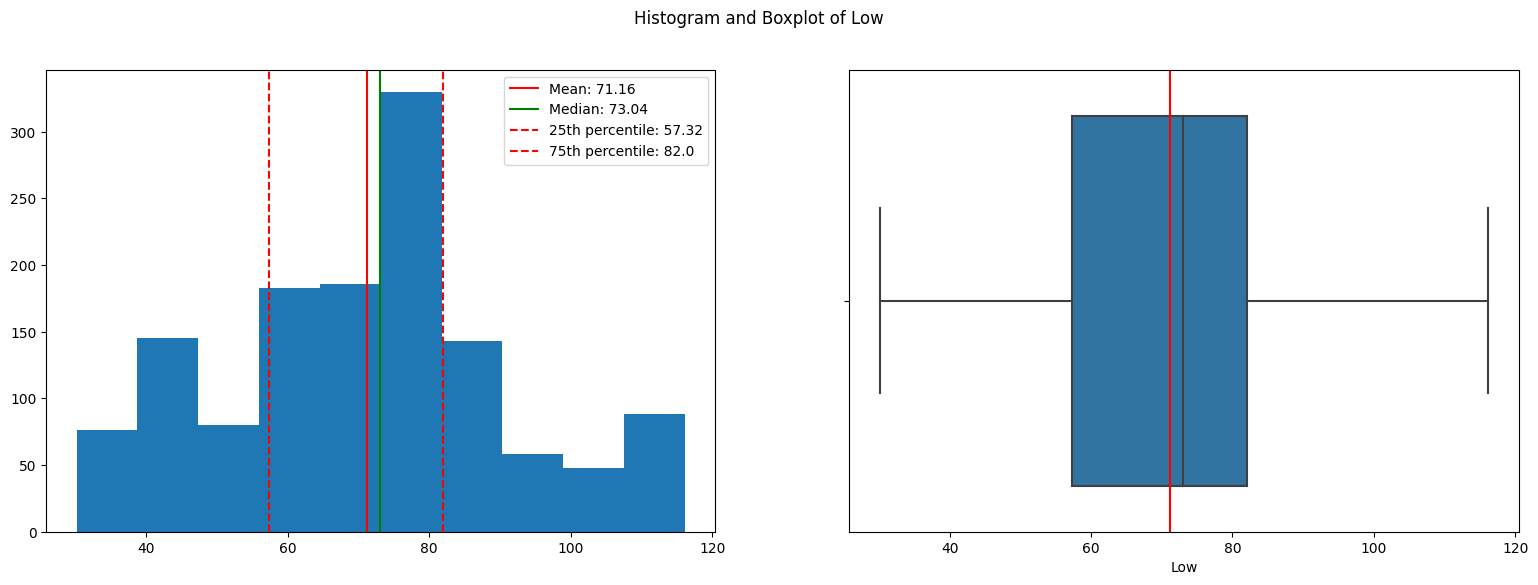

count    1337.000
mean       71.163
std        20.118
min        30.110
25%        57.320
50%        73.040
75%        82.000
max       116.160
Name: Low, dtype: float64

Range: 86.050003
Interquartile Range: 24.68

Skewness: 0.09910848313670854
Kurtosis: -0.4227718870682571


In [ ]:
descriptive_summary(columns[2])

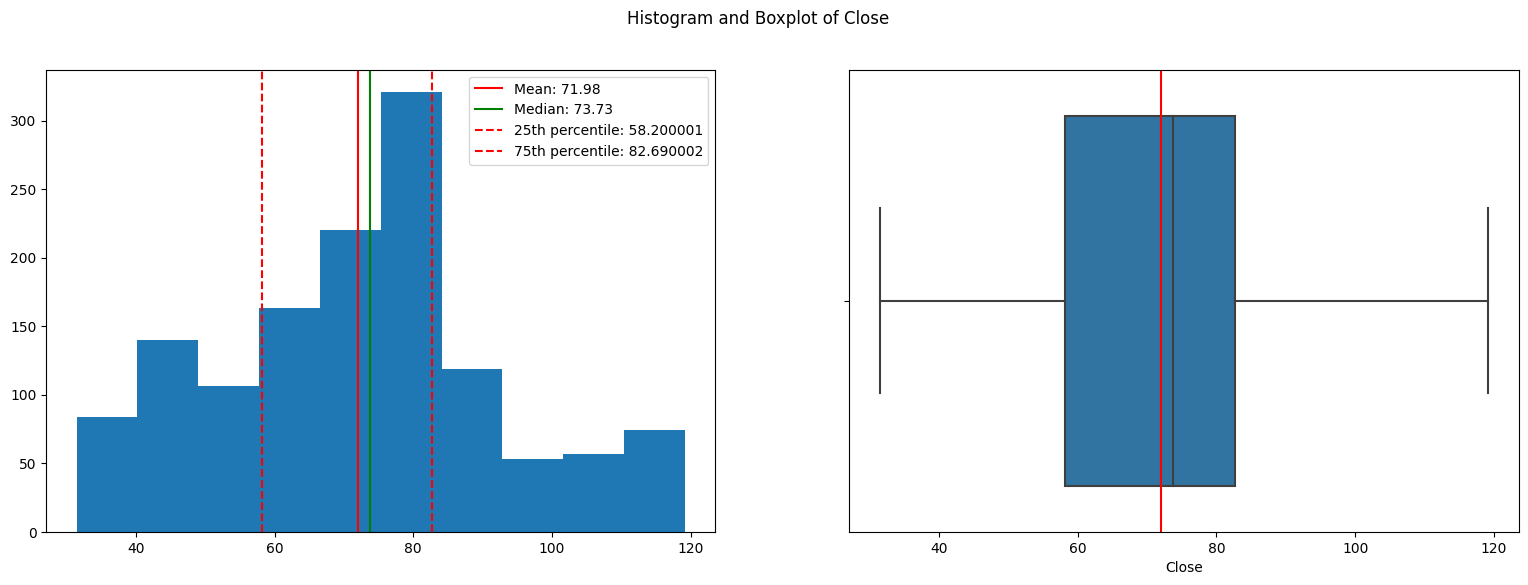

count    1337.000
mean       71.981
std        20.321
min        31.450
25%        58.200
50%        73.730
75%        82.690
max       119.170
Name: Close, dtype: float64

Range: 87.719997
Interquartile Range: 24.490001000000007

Skewness: 0.12768236457993015
Kurtosis: -0.416871903223218


In [ ]:
descriptive_summary(columns[3])

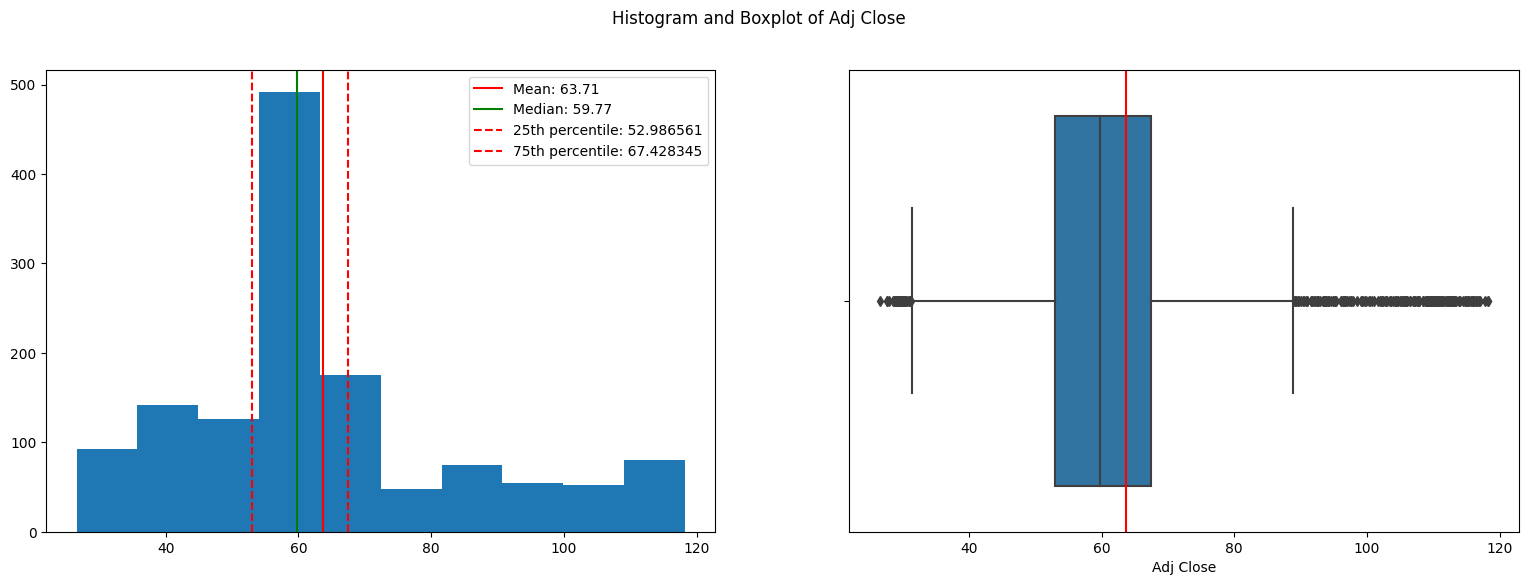

count    1337.000
mean       63.709
std        21.213
min        26.565
25%        52.987
50%        59.767
75%        67.428
max       118.260
Name: Adj Close, dtype: float64

Range: 91.695499
Interquartile Range: 14.441783999999991

Skewness: 0.8079885737038286
Kurtosis: 0.19365326421185358


In [ ]:
descriptive_summary(columns[4])

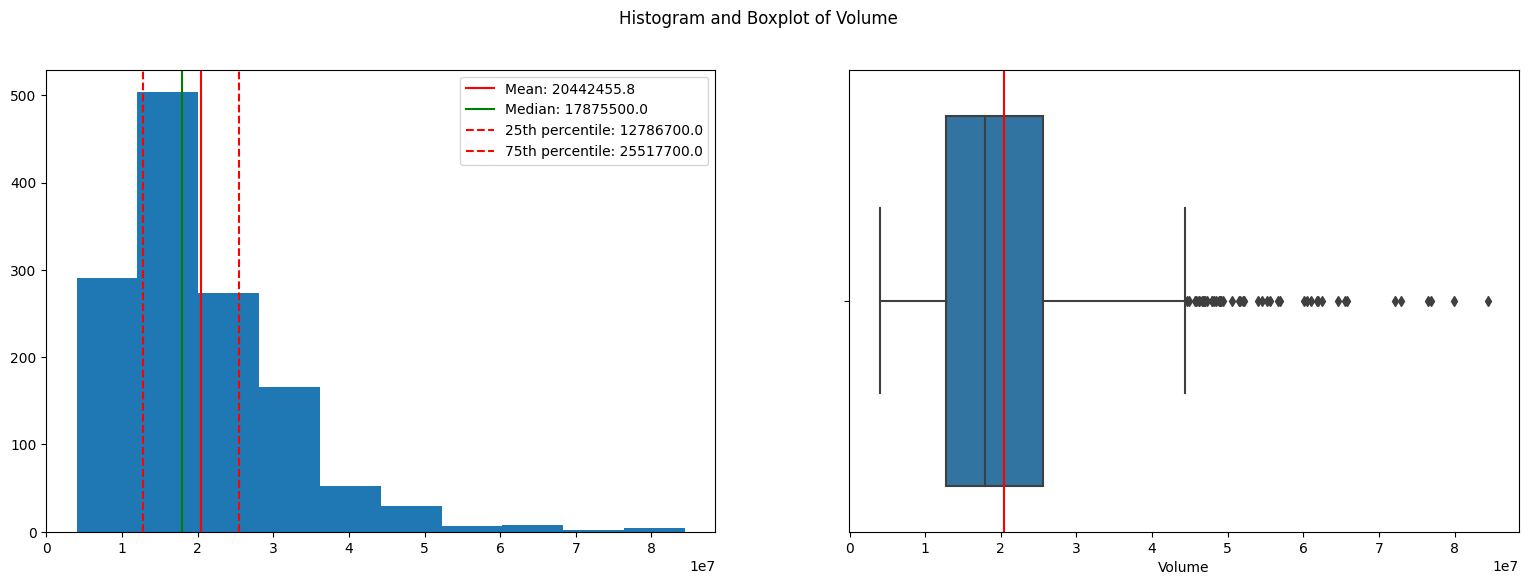

count    1.337000e+03
mean     2.044246e+07
std      1.081068e+07
min      3.979400e+06
25%      1.278670e+07
50%      1.787550e+07
75%      2.551770e+07
max      8.443940e+07
Name: Volume, dtype: float64

Range: 80460000
Interquartile Range: 12731000.0

Skewness: 1.6755512763350935
Kurtosis: 4.340815798165391


In [ ]:
descriptive_summary(columns[5])



> ***Data processing***


> 1.   Devide train/validate/test 7/2/1


> 2.   Data processing


In [ ]:
import torch
import mxnet as mx
from gluonts.mx import DeepAREstimator
from gluonts.mx.trainer import Trainer

In [ ]:
train_data = df[:int(0.7*len(df))]
val_data = df[int(0.7*len(df)):int(0.9*len(df))]
test_data = df[int(0.9*len(df)):]
val_data

,Date,Open,High,Low,Close,Adj Close,Volume
935,2021-09-20,53.779999,54.169998,52.959999,53.689999,50.567451,27555100
936,2021-09-21,54.369999,54.509998,53.250000,53.639999,50.520359,19696800
937,2021-09-22,54.430000,55.910000,54.369999,55.209999,51.999050,25690600
938,2021-09-23,55.419998,57.240002,55.279999,57.080002,53.760292,23069400
939,2021-09-24,56.700001,57.820000,56.680000,57.590000,54.240635,22328600
...,...,...,...,...,...,...,...
1198,2022-10-05,95.750000,99.989998,95.660004,99.120003,97.577583,34857700
1199,2022-10-06,98.470001,102.180000,98.330002,102.059998,100.471832,29124700
1200,2022-10-07,102.190002,103.320000,100.180000,101.029999,99.457863,24507600
1201,2022-10-10,101.489998,102.029999,98.720001,98.839996,97.301941,16786100


In [ ]:
pd.infer_freq(df.index)

'N'

In [ ]:
from gluonts.dataset.common import ListDataset

In [ ]:
# train_data.index = pd.to_datetime(train_data['Date'])
# val_data.index = pd.to_datetime(val_data['Date'])



In [102]:
training_data = [{"start":  pd.Timestamp(df['Date'][0]), "target": df['Close'][:int(0.7*len(df))]}]
valing_data = [{"start": pd.Timestamp(df['Date'][int(0.7*len(df))]), "target": df['Close'][int(0.7*len(df)):int(0.9*len(df))]}]
testing_data = [{"start": df['Date'][0], "target": df['Close'][int(0.9*len(df)):]}]

train_ds = ListDataset(training_data, freq='1D')
val_ds = ListDataset(valing_data, freq='1D')
train_ds


[{'start': Period('2018-01-02', 'D'),
  'target': array([85.03, 86.7 , 86.82, 86.75, 87.14, 86.77, 86.08, 86.93, 87.52,
         86.97, 88.  , 87.43, 87.15, 88.25, 88.3 , 88.53, 88.37, 89.  ,
         88.01, 86.78, 87.3 , 89.07, 84.53, 79.72, 78.35, 76.94, 76.07,
         75.78, 76.42, 76.3 , 76.46, 76.21, 76.54, 75.75, 74.89, 75.86,
         77.53, 78.84, 77.5 , 75.74, 75.2 , 75.55, 76.27, 76.18, 74.26,
         74.12, 74.56, 75.24, 74.53, 73.6 , 74.42, 75.12, 74.15, 73.99,
         75.04, 73.5 , 72.89, 74.  , 73.7 , 72.81, 74.61, 73.22, 75.02,
         74.87, 76.02, 74.87, 74.87, 77.07, 77.43, 77.22, 77.84, 78.54,
         78.33, 79.22, 79.42, 79.  , 79.57, 78.35, 79.5 , 80.86, 77.79,
         77.75, 76.95, 76.8 , 76.54, 76.9 , 77.74, 78.09, 79.93, 81.72,
         81.28, 81.83, 81.79, 82.02, 81.88, 81.3 , 82.28, 81.64, 82.15,
         80.27, 78.71, 78.42, 81.5 , 81.24, 81.83, 80.97, 80.68, 82.06,
         82.88, 83.6 , 83.1 , 82.42, 81.51, 81.89, 80.66, 80.82, 80.7 ,
         80.45, 

In [124]:
estimator = DeepAREstimator(
    freq="1D",
    prediction_length=935,
    context_length=90,
    trainer=Trainer(ctx="cpu", epochs=100),
    num_layers=2,
    num_cells=40,
    use_feat_dynamic_real=False,
    use_feat_static_cat=False,
    cardinality=[2],
)

In [ ]:
predictor = estimator.train(training_data=train_ds)



> ***Sử dụng make_evaluation_predictions: Kết quả không tốt***



In [ ]:
from gluonts.evaluation.backtest import make_evaluation_predictions


In [121]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset= val_ds, # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts=list(forecast_it)
tss=list(ts_it)


In [106]:
for i in forecast_it:
  print(i)

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[-2.01431528e-11, -8.56108934e-11,  8.93727106e-11, ...,
        -1.53048255e-10, -5.39277373e-11, -3.45275579e-11],
       [-7.30629585e-11,  5.47355529e-11,  6.76682529e-11, ...,
         1.50943480e-10,  2.23030025e-10,  4.80790963e-11],
       [ 1.64000202e-11, -6.25994256e-11, -2.90696633e-10, ...,
         8.00633559e-10, -7.61125329e-11,  2.43536302e-11],
       ...,
       [ 1.39413814e-09,  4.33578659e-11,  1.59796426e-10, ...,
        -1.06952038e-10, -1.17513832e-10, -9.92939619e-11],
       [ 1.78814845e-11, -7.60471824e-11,  4.83858786e-10, ...,
         2.46586557e-10, -3.26697391e-10,  4.11348698e-11],
       [ 4.80312456e-11,  1.00760331e-10,  7.89317153e-11, ...,
         8.55282026e-11,  2.35825359e-10,  1.00264255e-10]], dtype=float32), start_date=Period('2021-09-20', 'D'))




> ***Sử dụng predict***



In [110]:
prediction = next(predictor.predict(train_ds))
forecast = prediction.mean.tolist()


In [111]:
print(f"Forecast for the next {len(forecast)} days: {forecast}")


Forecast for the next 268 days: [55.464778900146484, 55.66495132446289, 56.64508819580078, 57.45771408081055, 57.7781867980957, 57.863983154296875, 57.47761535644531, 57.299156188964844, 56.51787185668945, 56.987884521484375, 57.42482376098633, 57.84858322143555, 58.034423828125, 58.16985321044922, 57.88624954223633, 58.13774490356445, 59.20701217651367, 60.19147872924805, 60.25593566894531, 60.022151947021484, 60.074588775634766, 60.057342529296875, 59.66233444213867, 59.9216423034668, 60.232421875, 59.840736389160156, 59.231014251708984, 58.72722244262695, 58.21892166137695, 57.945011138916016, 58.55308151245117, 58.97740173339844, 58.79655456542969, 58.2786979675293, 58.19805145263672, 57.95899963378906, 57.92398452758789, 58.43157196044922, 58.948646545410156, 58.860450744628906, 58.776309967041016, 58.497833251953125, 58.58012771606445, 58.73491668701172, 60.21467590332031, 61.017425537109375, 61.5203857421875, 61.32160568237305, 61.1180534362793, 60.95101547241211, 60.66567230224

In [116]:
close=val_data.Close.tolist()
actual_temps=val_data.Date.tolist()

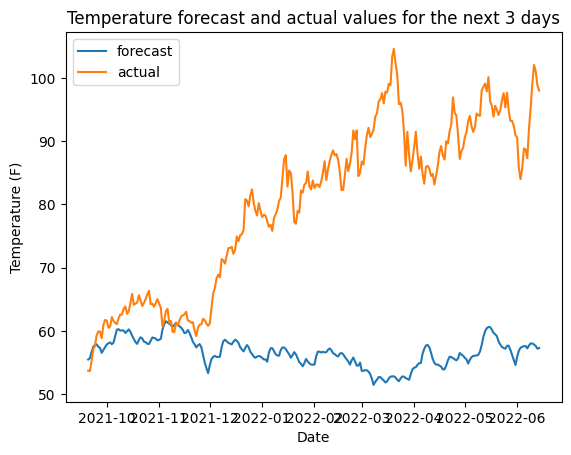

In [119]:
actual_dates = pd.date_range(start='2021-09-20', periods=len(actual_temps), freq=freq)

# plot the temperature forecast and actual temperatures
plt.plot(actual_dates, forecast, label='forecast')
plt.plot(actual_dates, close, label='actual')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.title('Temperature forecast and actual values for the next 3 days')
plt.legend()
plt.show()

In [122]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss ), iter(forecasts), num_series=len(val_ds))
#print(agg_metrics)
item_metrics


Running evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/astype.py:170: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,...,QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.6],Coverage[0.6],QuantileLoss[0.7],Coverage[0.7],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.9],Coverage[0.9]
0,None,2021-09-20,6584.138526,21455.970703,21455.970703,80.059592,NaN,NaN,1.0,2.0,...,21455.969929,0.0,25747.163914,0.0,30038.3579,0.0,34329.551886,0.0,38620.745872,0.0


In [ ]:
for i in range(len(tss)):
    tss[i].index = tss[i].index.to_timestamp()